In [ ]:
!wget https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
!apt install -y ./google-chrome-stable_current_amd64.deb
!apt-get install -y chromium-chromedriver
!pip install -q selenium beautifulsoup4

--2026-01-07 18:27:30--  https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
Resolving dl.google.com (dl.google.com)... 74.125.132.91, 74.125.132.136, 74.125.132.190, ...
Connecting to dl.google.com (dl.google.com)|74.125.132.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 117896052 (112M) [application/x-debian-package]
Saving to: ‘google-chrome-stable_current_amd64.deb.1’

google-chrome-stabl 100%[===================>] 112.43M   278MB/s    in 0.4s    

2026-01-07 18:27:31 (278 MB/s) - ‘google-chrome-stable_current_amd64.deb.1’ saved [117896052/117896052]

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'google-chrome-stable' instead of './google-chrome-stable_current_amd64.deb'
google-chrome-stable is already the newest version (143.0.7499.192-1).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.
Reading package lists... Done
Building dependency tree... Done

In [ ]:
!pip install -q selenium webdriver-manager beautifulsoup4

# **Remoteok Scraping **

The scraping process uses Selenium to load the RemoteOK website in headless mode and automatically scrolls through the page until all job listings are fully loaded. The complete HTML content is saved locally and then parsed using BeautifulSoup. Key job details such as job title, company, skills, location, job type, posting date, and job URL are extracted. The collected data is structured and saved into a CSV file for easy analysis and further processing.

Remoteok website link:https://remoteok.com/

In [ ]:
import time
import csv
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup

# Chrome options for Colab
chrome_options = Options()
chrome_options.binary_location = "/usr/bin/google-chrome"
chrome_options.add_argument("--headless")
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")
chrome_options.add_argument("--window-size=1920,1080")


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=chrome_options)

try:
    URL = "https://remoteok.com/remote-jobs"
    driver.get(URL)
    time.sleep(2)

    # Scroll to load all jobs
    last_height = driver.execute_script("return document.body.scrollHeight")
    while True:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(2)
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height


    with open("raw_remoteok.html", "w", encoding="utf-8") as f:
        f.write(driver.page_source)

    # Parse HTML
    soup = BeautifulSoup(driver.page_source, "html.parser")
    jobs_data = []

    for job in soup.find_all("tr", class_="job"):
        # Job Title & URL
        title_tag = job.find("h2")
        link_tag = job.find("a", class_="preventLink")
        job_title = title_tag.text.strip() if title_tag else None
        job_url = "https://remoteok.com" + link_tag.get("href") if link_tag else None

        # Company
        company_tag = job.find("h3")
        company = company_tag.text.strip() if company_tag else None

        # Skills / Tags
        skills = []
        tags_td = job.find("td", class_="tags")
        if tags_td:
            for tag_div in tags_td.find_all("div", class_="tag"):
                h3 = tag_div.find("h3")
                if h3:
                    skills.append(h3.text.strip())

        # Location
        location = None
        location_div = job.find("div", class_="location")
        if location_div:
            text = location_div.text.strip()
            if "upgrade" not in text.lower() and "premium" not in text.lower():
                location = text
        if not location:
            expand_row = job.find_next_sibling("tr", class_="expand")
            if expand_row:
                desc = expand_row.find("div", class_="description")
                if desc:
                    loc_header = desc.find("h1", id="location")
                    if loc_header:
                        loc_p = loc_header.find_next_sibling("p")
                        if loc_p:
                            location = loc_p.text.strip()
        if not location:
            location = "Remote"

        # Job Type
        job_type_tag = job.find("span", class_="contract")
        job_type = job_type_tag.text.strip() if job_type_tag else "Not specified"

        # Date Posted
        date_tag = job.find("time")
        date_posted = date_tag.get("datetime") if date_tag else None

        jobs_data.append({
            "Job Title": job_title,
            "Company": company,
            "Skills": ", ".join(skills),
            "Location": location,
            "Job Type": job_type,
            "Date Posted": date_posted,
            "Job URL": job_url
        })

    # Save CSV
    OUTPUT_FILE = "remoteok_raw.csv"
    with open(OUTPUT_FILE, "w", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(
            f,
            fieldnames=[
                "Job Title",
                "Company",
                "Skills",
                "Location",
                "Job Type",
                "Date Posted",
                "Job URL"
            ]
        )
        writer.writeheader()
        writer.writerows(jobs_data)

    print(f"Successfully scraped {len(jobs_data)} jobs")
    print(f"CSV saved as: {OUTPUT_FILE}")
    print("Raw HTML saved as: raw_remoteok.html")

finally:
    driver.quit()
    print("Browser closed safely.")

Successfully scraped 1044 jobs
CSV saved as: remoteok_raw.csv
Raw HTML saved as: raw_remoteok.html
Browser closed safely.


In [ ]:
from google.colab import files
files.download("remoteok_raw.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install -q pandas numpy

In [ ]:
import pandas as pd
import numpy as np

def clean_remoteok_data(input_file="remoteok_raw.csv", output_file="remoteok_jobs_cleaned.csv"):
    """
    Clean RemoteOK job data following Evoastra rules.
    """
    print("=== Starting Data Cleaning ===")

    # 1. Load data
    try:
        df = pd.read_csv(input_file)
        print(f"✓ Loaded: {df.shape[0]} rows")
    except FileNotFoundError:
        print(f"✗ Error: File '{input_file}' not found")
        return

    # 2. Handle missing values
    critical_cols = ['Job Title', 'Company', 'Skills']
    df_cleaned = df.dropna(subset=critical_cols).copy()
    df_cleaned[['Location', 'Job Type']] = df_cleaned[['Location', 'Job Type']].fillna('not_specified')

    # 3. Remove duplicates
    df_cleaned = df_cleaned.drop_duplicates(subset=['Job Title', 'Company', 'Job URL'])

    # 4. Clean text
    text_cols = ['Job Title', 'Company', 'Location', 'Job Type']
    for col in text_cols:
        df_cleaned[col] = df_cleaned[col].astype(str).str.lower().str.strip()

    # 5. Remove emojis from Location
    df_cleaned['Location'] = df_cleaned['Location'].str.encode('ascii', 'ignore').str.decode('ascii').str.strip()

    # 6. Clean skills
    def clean_skills(skills):
        if isinstance(skills, str):
            skills = skills.lower().strip()
            skill_list = [skill.strip() for skill in skills.split(',')]
            skill_list = [s for s in skill_list if s]
            unique_skills = list(dict.fromkeys(skill_list))
            return ', '.join(unique_skills)
        return skills

    df_cleaned['Skills'] = df_cleaned['Skills'].apply(clean_skills)

    # 7. Fix dates (keep only YYYY-MM-DD)
    df_cleaned['Date Posted'] = df_cleaned['Date Posted'].astype(str).str[:10]

    # 8. Save cleaned data
    df_cleaned.to_csv(output_file, index=False)

    # 9. Print summary
    print("✓ Cleaning Summary:")
    print(f"  Original: {df.shape[0]} rows")
    print(f"  Cleaned:  {df_cleaned.shape[0]} rows")
    print(f"  Removed:  {df.shape[0] - df_cleaned.shape[0]} rows")
    print(f"✓ Saved as: '{output_file}'")
    print("=== Cleaning Complete ===")

    return df_cleaned

# Run cleaning after scraping
cleaned_df = clean_remoteok_data()

=== Starting Data Cleaning ===
✓ Loaded: 1044 rows
✓ Cleaning Summary:
  Original: 1044 rows
  Cleaned:  1001 rows
  Removed:  43 rows
✓ Saved as: 'remoteok_jobs_cleaned.csv'
=== Cleaning Complete ===


In [ ]:
from google.colab import files
files.download("remoteok_jobs_cleaned.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import logging
import sys

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from matplotlib.gridspec import GridSpec

sns.set_style("whitegrid")
plt.rcParams.update({
    "figure.dpi": 120,
    "font.family": "sans-serif"
})

In [ ]:
# Google Drive Mount (Colab Only)

from google.colab import drive

try:
    drive.mount("/content/drive")
    print("Google Drive mounted successfully")
except Exception as e:
    raise RuntimeError("Google Drive mount failed") from e

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully


In [ ]:
# Base directory inside Google Drive
BASE_DIR = Path("/content/drive/MyDrive/RemoteOK_Visualization")

DATA_DIR = BASE_DIR / "data" / "remoteok"
OUTPUT_DIR = BASE_DIR / "outputs"

PLOTS_DIR = OUTPUT_DIR / "plots"
DASHBOARD_DIR = OUTPUT_DIR / "dashboard"
LOG_DIR = OUTPUT_DIR / "logs"

# Create directories safely
for d in [DATA_DIR, PLOTS_DIR, DASHBOARD_DIR, LOG_DIR]:
    d.mkdir(parents=True, exist_ok=True)

In [ ]:
# ---------------- SAFE DATA LOADING (FIXED) ---------------- #

import logging

# Ensure logger exists (do NOT reconfigure if already present)
if "logger" not in globals():
    logging.basicConfig(
        level=logging.INFO,
        format="%(asctime)s | %(levelname)s | %(message)s"
    )
    logger = logging.getLogger("RemoteOK")

DATA_FILE = Path("remoteok_jobs_cleaned.csv")

if not DATA_FILE.exists():
    raise FileNotFoundError(
        f"Dataset not found at {DATA_FILE}. "
        "Please place the cleaned CSV in the data/remoteok folder."
    )

raw_df = pd.read_csv(DATA_FILE)
logger.info(f"Raw dataset loaded successfully | Shape: {raw_df.shape}")

In [ ]:
# ---------------- FINAL MINIMAL FIXES ---------------- #

if 'raw_df' not in globals():
    raw_df = pd.read_csv("remoteok_jobs_cleaned.csv")

# Defensive check
if "raw_df" not in globals():
    raise NameError(
        "raw_df is not defined. Please run the data loading cell before this step."
    )

# Remove duplicates
before = raw_df.shape[0]
df = raw_df.drop_duplicates().copy()
after = df.shape[0]

logger.info(f"Duplicates removed: {before - after}")

# Convert Date Posted to datetime
df["date_posted"] = pd.to_datetime(df["Date Posted"], errors="coerce")

# Validate date conversion
invalid_dates = df["date_posted"].isna().sum()
if invalid_dates > 0:
    logger.warning(f"{invalid_dates} invalid dates were coerced to NaT")

# Create analytical feature
df["days_since_posted"] = (
    pd.Timestamp.now() - df["date_posted"]
).dt.days

logger.info("Minimal fixes applied successfully")

In [ ]:
assert df.isna().sum().sum() == 0, "Nulls detected after fixes"
assert df.duplicated().sum() == 0, "Duplicates still present"

logger.info("Post-fix validation passed")

In [ ]:
df["skills_list"] = (
    df["Skills"]
    .str.lower()
    .str.replace(r"[^a-zA-Z,+ ]", "", regex=True)
    .str.split(",")
)

df_skills = df.explode("skills_list")
df_skills["skills_list"] = df_skills["skills_list"].str.strip()

logger.info("Skills normalization and explosion completed")

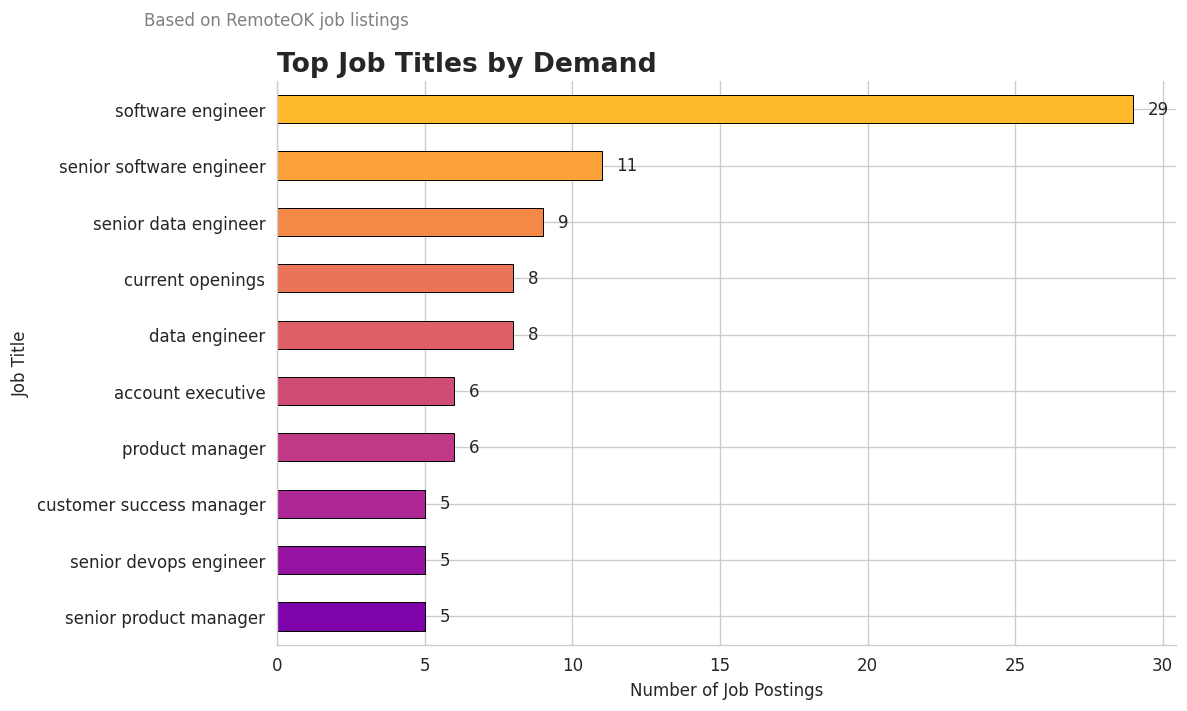

In [ ]:
# ================================
# PLOT 1: Top 10 Job Titles by Demand
# ================================

top_titles = (
    df["Job Title"]
    .value_counts()
    .head(10)
    .sort_values()
)

colors = cm.plasma(np.linspace(0.25, 0.85, len(top_titles)))

plt.figure(figsize=(10, 6))
ax = top_titles.plot(
    kind="barh",
    color=colors,
    edgecolor="black",
    linewidth=0.6
)

ax.set_title("Top Job Titles by Demand", fontsize=16, weight="bold", loc="left")
plt.suptitle("Based on RemoteOK job listings", fontsize=10, x=0.125, ha="left", color="gray")

ax.set_xlabel("Number of Job Postings")
ax.set_ylabel("Job Title")

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

for i, v in enumerate(top_titles.values):
    ax.text(v + 0.5, i, str(v), va="center", fontsize=10)

plt.tight_layout()
plt.savefig(PLOTS_DIR / "01_top_job_titles.png", dpi=300, bbox_inches="tight")
plt.show()

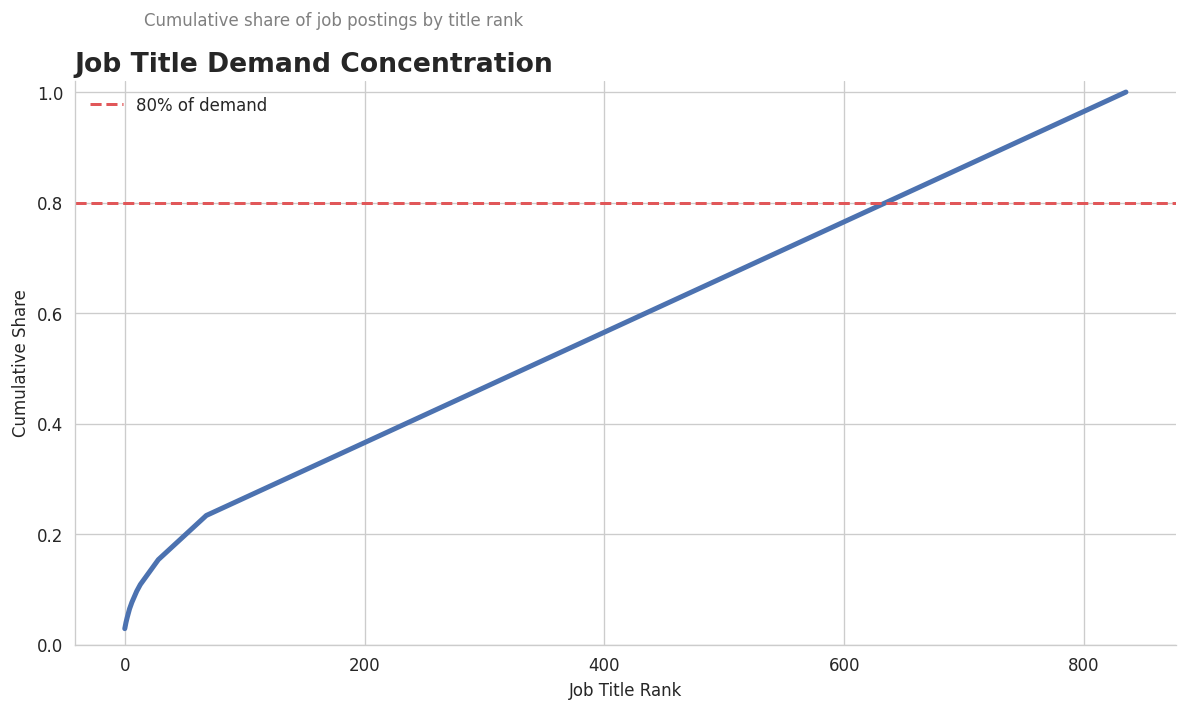

In [ ]:
# ================================
# PLOT 2: Job Title Demand Concentration
# ================================

counts = df["Job Title"].value_counts()
cumulative = counts.cumsum() / counts.sum()

plt.figure(figsize=(10, 6))
plt.plot(cumulative.values, linewidth=3, color="#4C72B0")

plt.axhline(0.8, linestyle="--", color="#E15759", linewidth=1.8, label="80% of demand")

plt.title("Job Title Demand Concentration", fontsize=16, weight="bold", loc="left")
plt.suptitle("Cumulative share of job postings by title rank",
             fontsize=10, x=0.125, ha="left", color="gray")

plt.xlabel("Job Title Rank")
plt.ylabel("Cumulative Share")

plt.ylim(0, 1.02)
plt.legend(frameon=False)

ax = plt.gca()
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.savefig(PLOTS_DIR / "02_job_title_concentration.png", dpi=300, bbox_inches="tight")
plt.show()

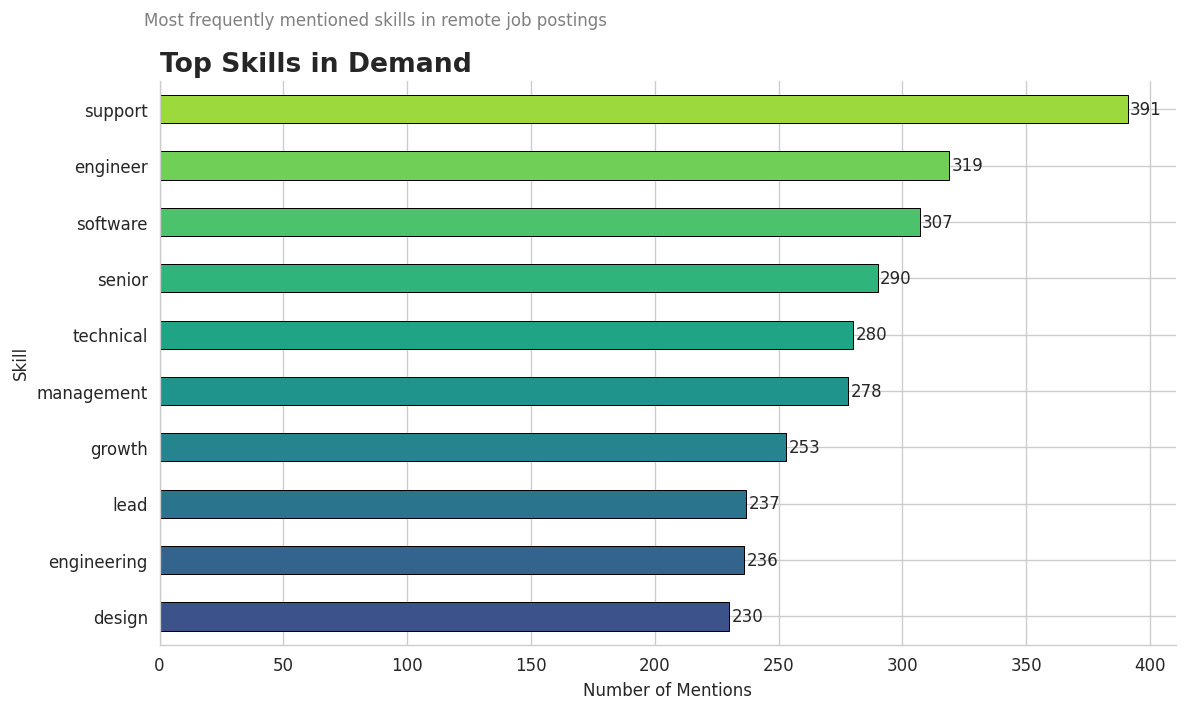

In [ ]:
# ================================
# PLOT 3: Top 10 Skills in Demand
# ================================

top_skills = (
    df_skills["skills_list"]
    .value_counts()
    .head(10)
    .sort_values()
)

colors = cm.viridis(np.linspace(0.25, 0.85, len(top_skills)))

plt.figure(figsize=(10, 6))
ax = top_skills.plot(
    kind="barh",
    color=colors,
    edgecolor="black",
    linewidth=0.6
)

ax.set_title("Top Skills in Demand", fontsize=16, weight="bold", loc="left")
plt.suptitle("Most frequently mentioned skills in remote job postings",
             fontsize=10, x=0.125, ha="left", color="gray")

ax.set_xlabel("Number of Mentions")
ax.set_ylabel("Skill")

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

for i, v in enumerate(top_skills.values):
    ax.text(v + 1, i, str(v), va="center", fontsize=10)

plt.tight_layout()
plt.savefig(PLOTS_DIR / "03_top_skills_demand.png", dpi=300, bbox_inches="tight")
plt.show()

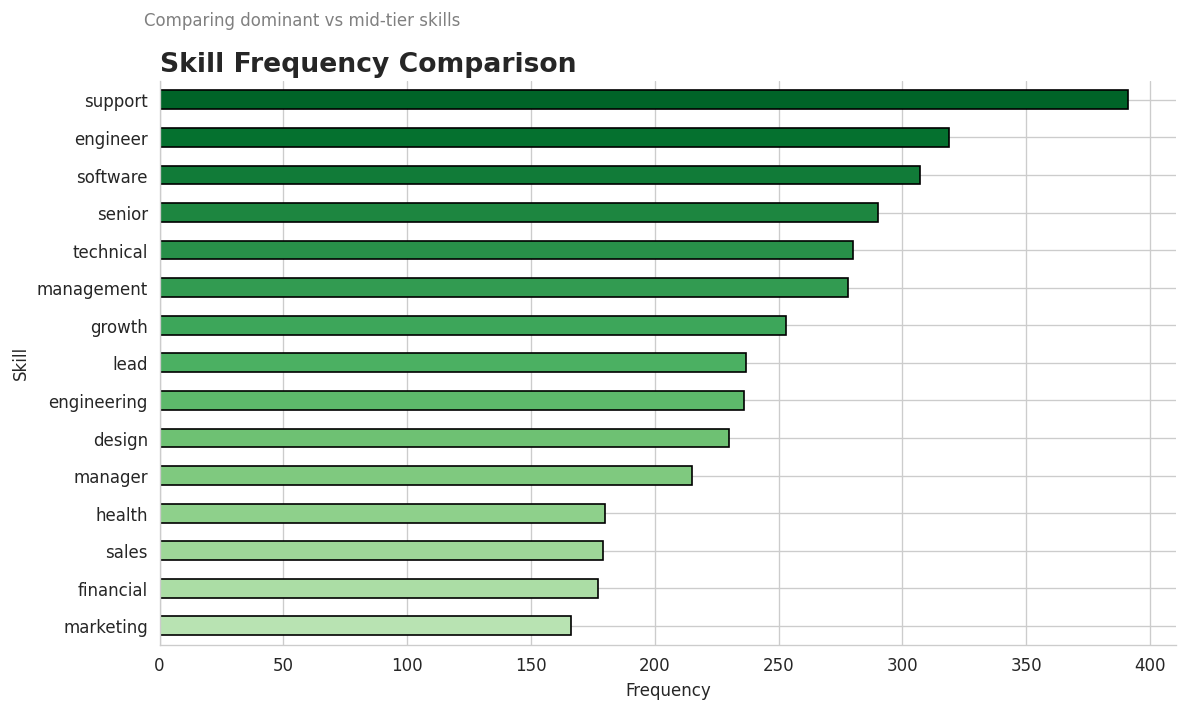

In [ ]:
# ================================
# PLOT 4: Skill Frequency Comparison
# ================================

top_skills_extended = (
    df_skills["skills_list"]
    .value_counts()
    .head(15)
    .sort_values()
)

plt.figure(figsize=(10, 6))
ax = top_skills_extended.plot(
    kind="barh",
    color=cm.Greens(np.linspace(0.3, 0.9, len(top_skills_extended))),
    edgecolor="black"
)

ax.set_title("Skill Frequency Comparison", fontsize=16, weight="bold", loc="left")
plt.suptitle("Comparing dominant vs mid-tier skills",
             fontsize=10, x=0.125, ha="left", color="gray")

ax.set_xlabel("Frequency")
ax.set_ylabel("Skill")

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.savefig(PLOTS_DIR / "04_skill_frequency_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

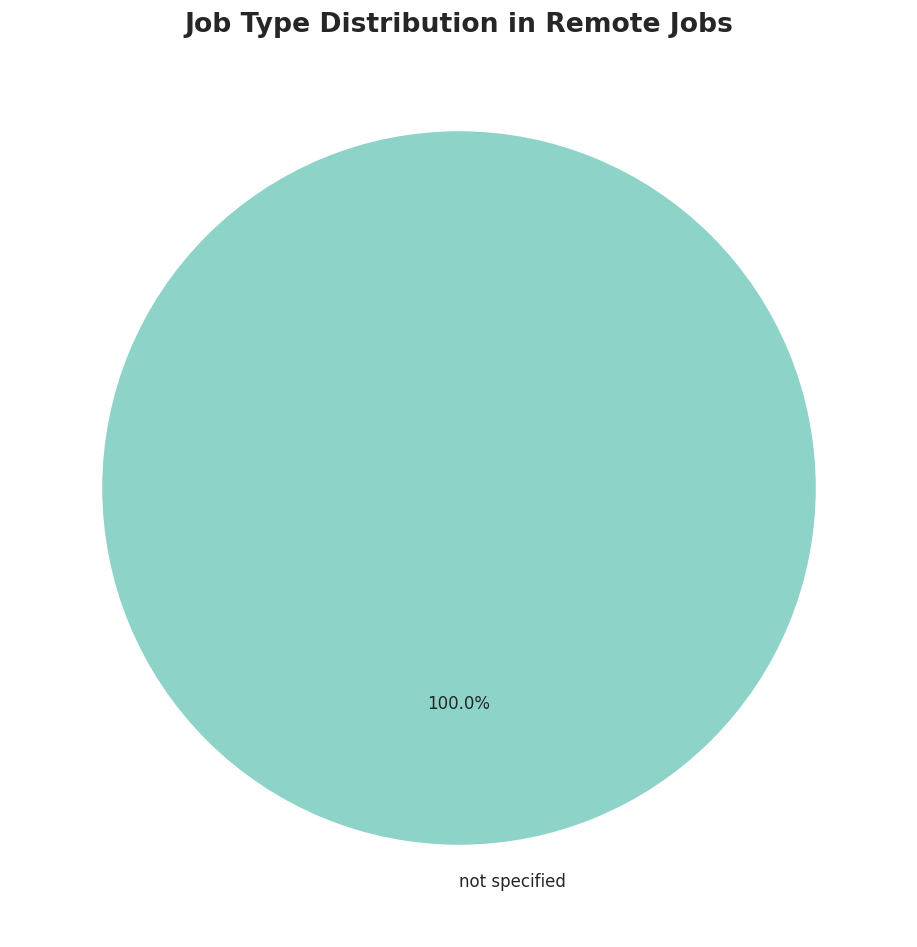

In [ ]:
# ================================
# PLOT 5: Job Type Distribution
# ================================

job_type_counts = df["Job Type"].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(
    job_type_counts,
    labels=job_type_counts.index,
    autopct="%1.1f%%",
    startangle=90,
    colors=cm.Set3.colors
)

plt.title("Job Type Distribution in Remote Jobs",
          fontsize=16, weight="bold")

plt.tight_layout()
plt.savefig(PLOTS_DIR / "05_job_type_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

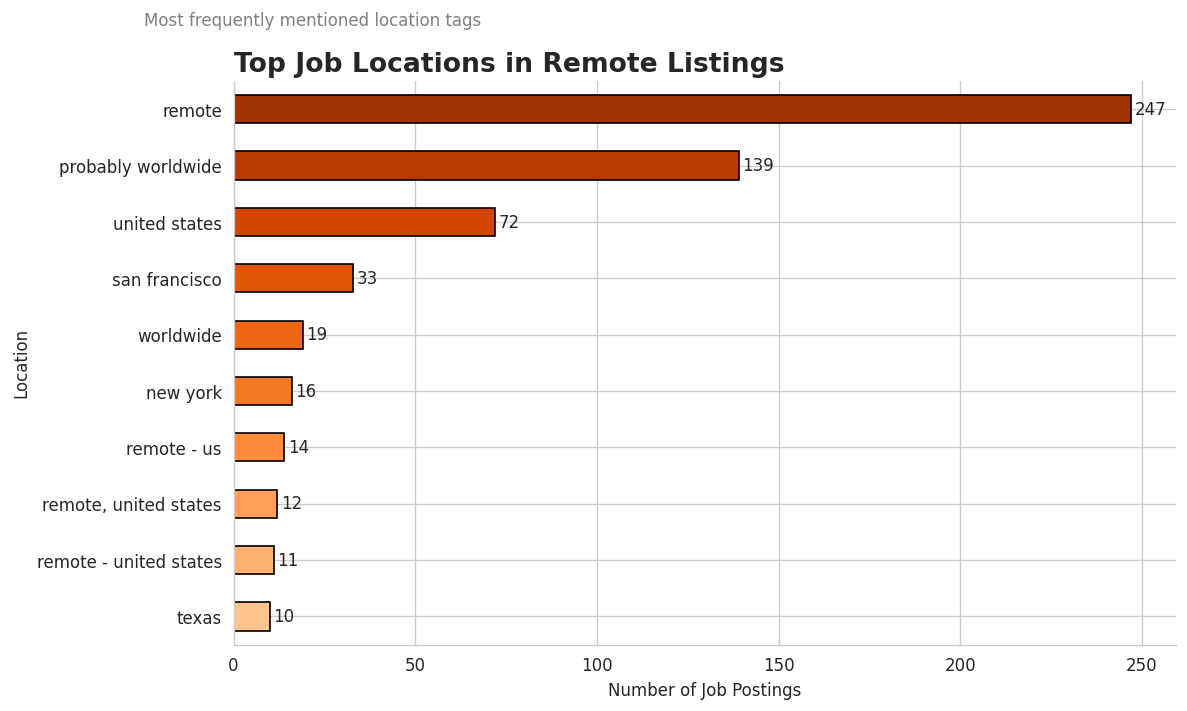

In [ ]:
# ================================
# PLOT 6: Top Job Locations
# ================================

top_locations = (
    df["Location"]
    .value_counts()
    .head(10)
    .sort_values()
)

plt.figure(figsize=(10, 6))
ax = top_locations.plot(
    kind="barh",
    color=cm.Oranges(np.linspace(0.3, 0.9, len(top_locations))),
    edgecolor="black"
)

ax.set_title("Top Job Locations in Remote Listings",
             fontsize=16, weight="bold", loc="left")
plt.suptitle("Most frequently mentioned location tags",
             fontsize=10, x=0.125, ha="left", color="gray")

ax.set_xlabel("Number of Job Postings")
ax.set_ylabel("Location")

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

for i, v in enumerate(top_locations.values):
    ax.text(v + 1, i, str(v), va="center", fontsize=10)

plt.tight_layout()
plt.savefig(PLOTS_DIR / "06_job_location_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

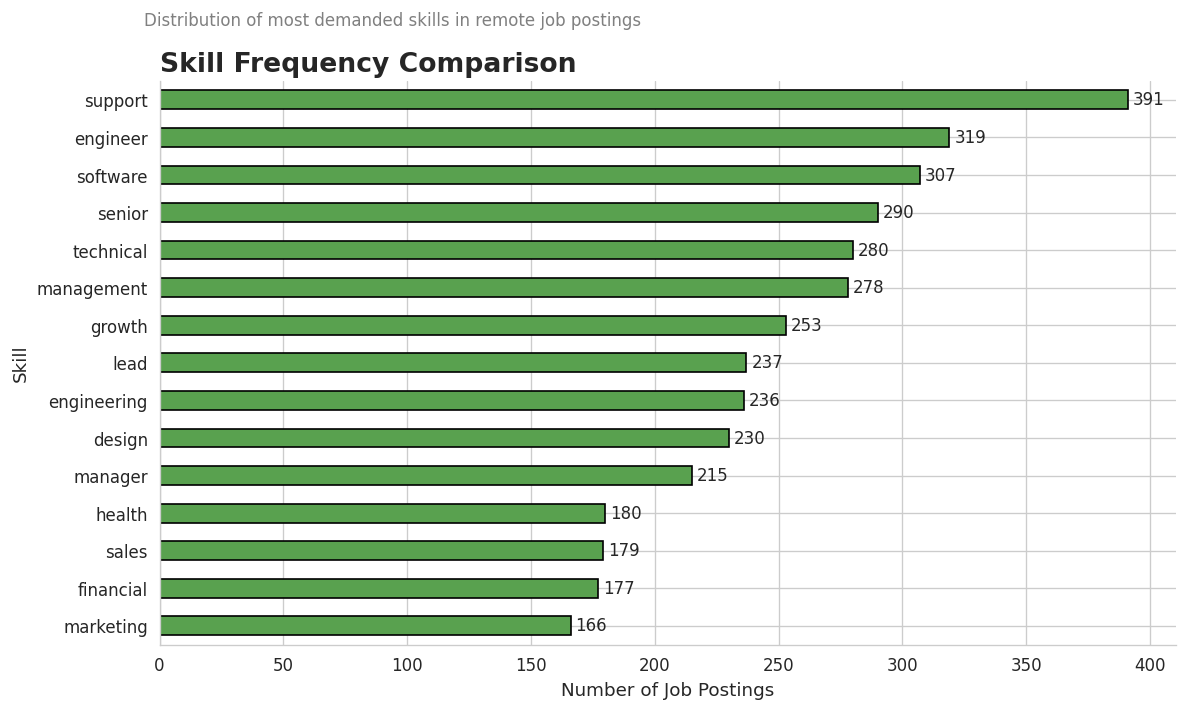

In [ ]:
# ================================
# PLOT 7: Skill Frequency Comparison
# ================================

skills_series = (
    df["Skills"]
    .dropna()
    .str.split(",")
    .explode()
    .str.strip()
)

top_skills = (
    skills_series
    .value_counts()
    .head(15)
    .sort_values()
)

plt.figure(figsize=(10, 6))
ax = top_skills.plot(
    kind="barh",
    color="#59A14F",
    edgecolor="black"
)

plt.title(
    "Skill Frequency Comparison",
    fontsize=16,
    weight="bold",
    loc="left"
)
plt.suptitle(
    "Distribution of most demanded skills in remote job postings",
    fontsize=10,
    x=0.125,
    ha="left",
    color="gray"
)

plt.xlabel("Number of Job Postings", fontsize=11)
plt.ylabel("Skill", fontsize=11)

# Value labels
for i, v in enumerate(top_skills.values):
    plt.text(v + 2, i, str(v), va="center", fontsize=10)

# Clean spines
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.savefig(
    PLOTS_DIR / "04_skill_frequency_comparison.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()

logger.info("Costas | Skill Frequency Comparison plot generated")

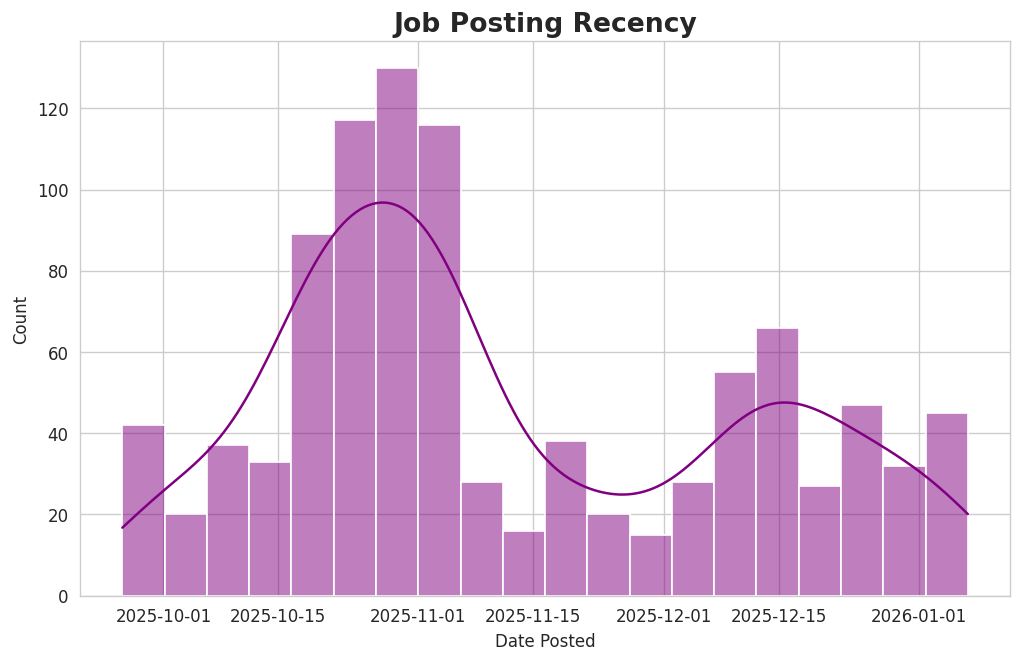

In [ ]:
# ================================
# PLOT 8: Job postings Over time
# ================================

plt.figure(figsize=(10, 6))
sns.histplot(df["date_posted"], bins=20, kde=True, color="purple")
plt.title("Job Posting Recency", fontsize=16, weight="bold")
plt.xlabel("Date Posted")
plt.savefig(PLOTS_DIR / "04_posting_recency.png", dpi=300)
plt.show()

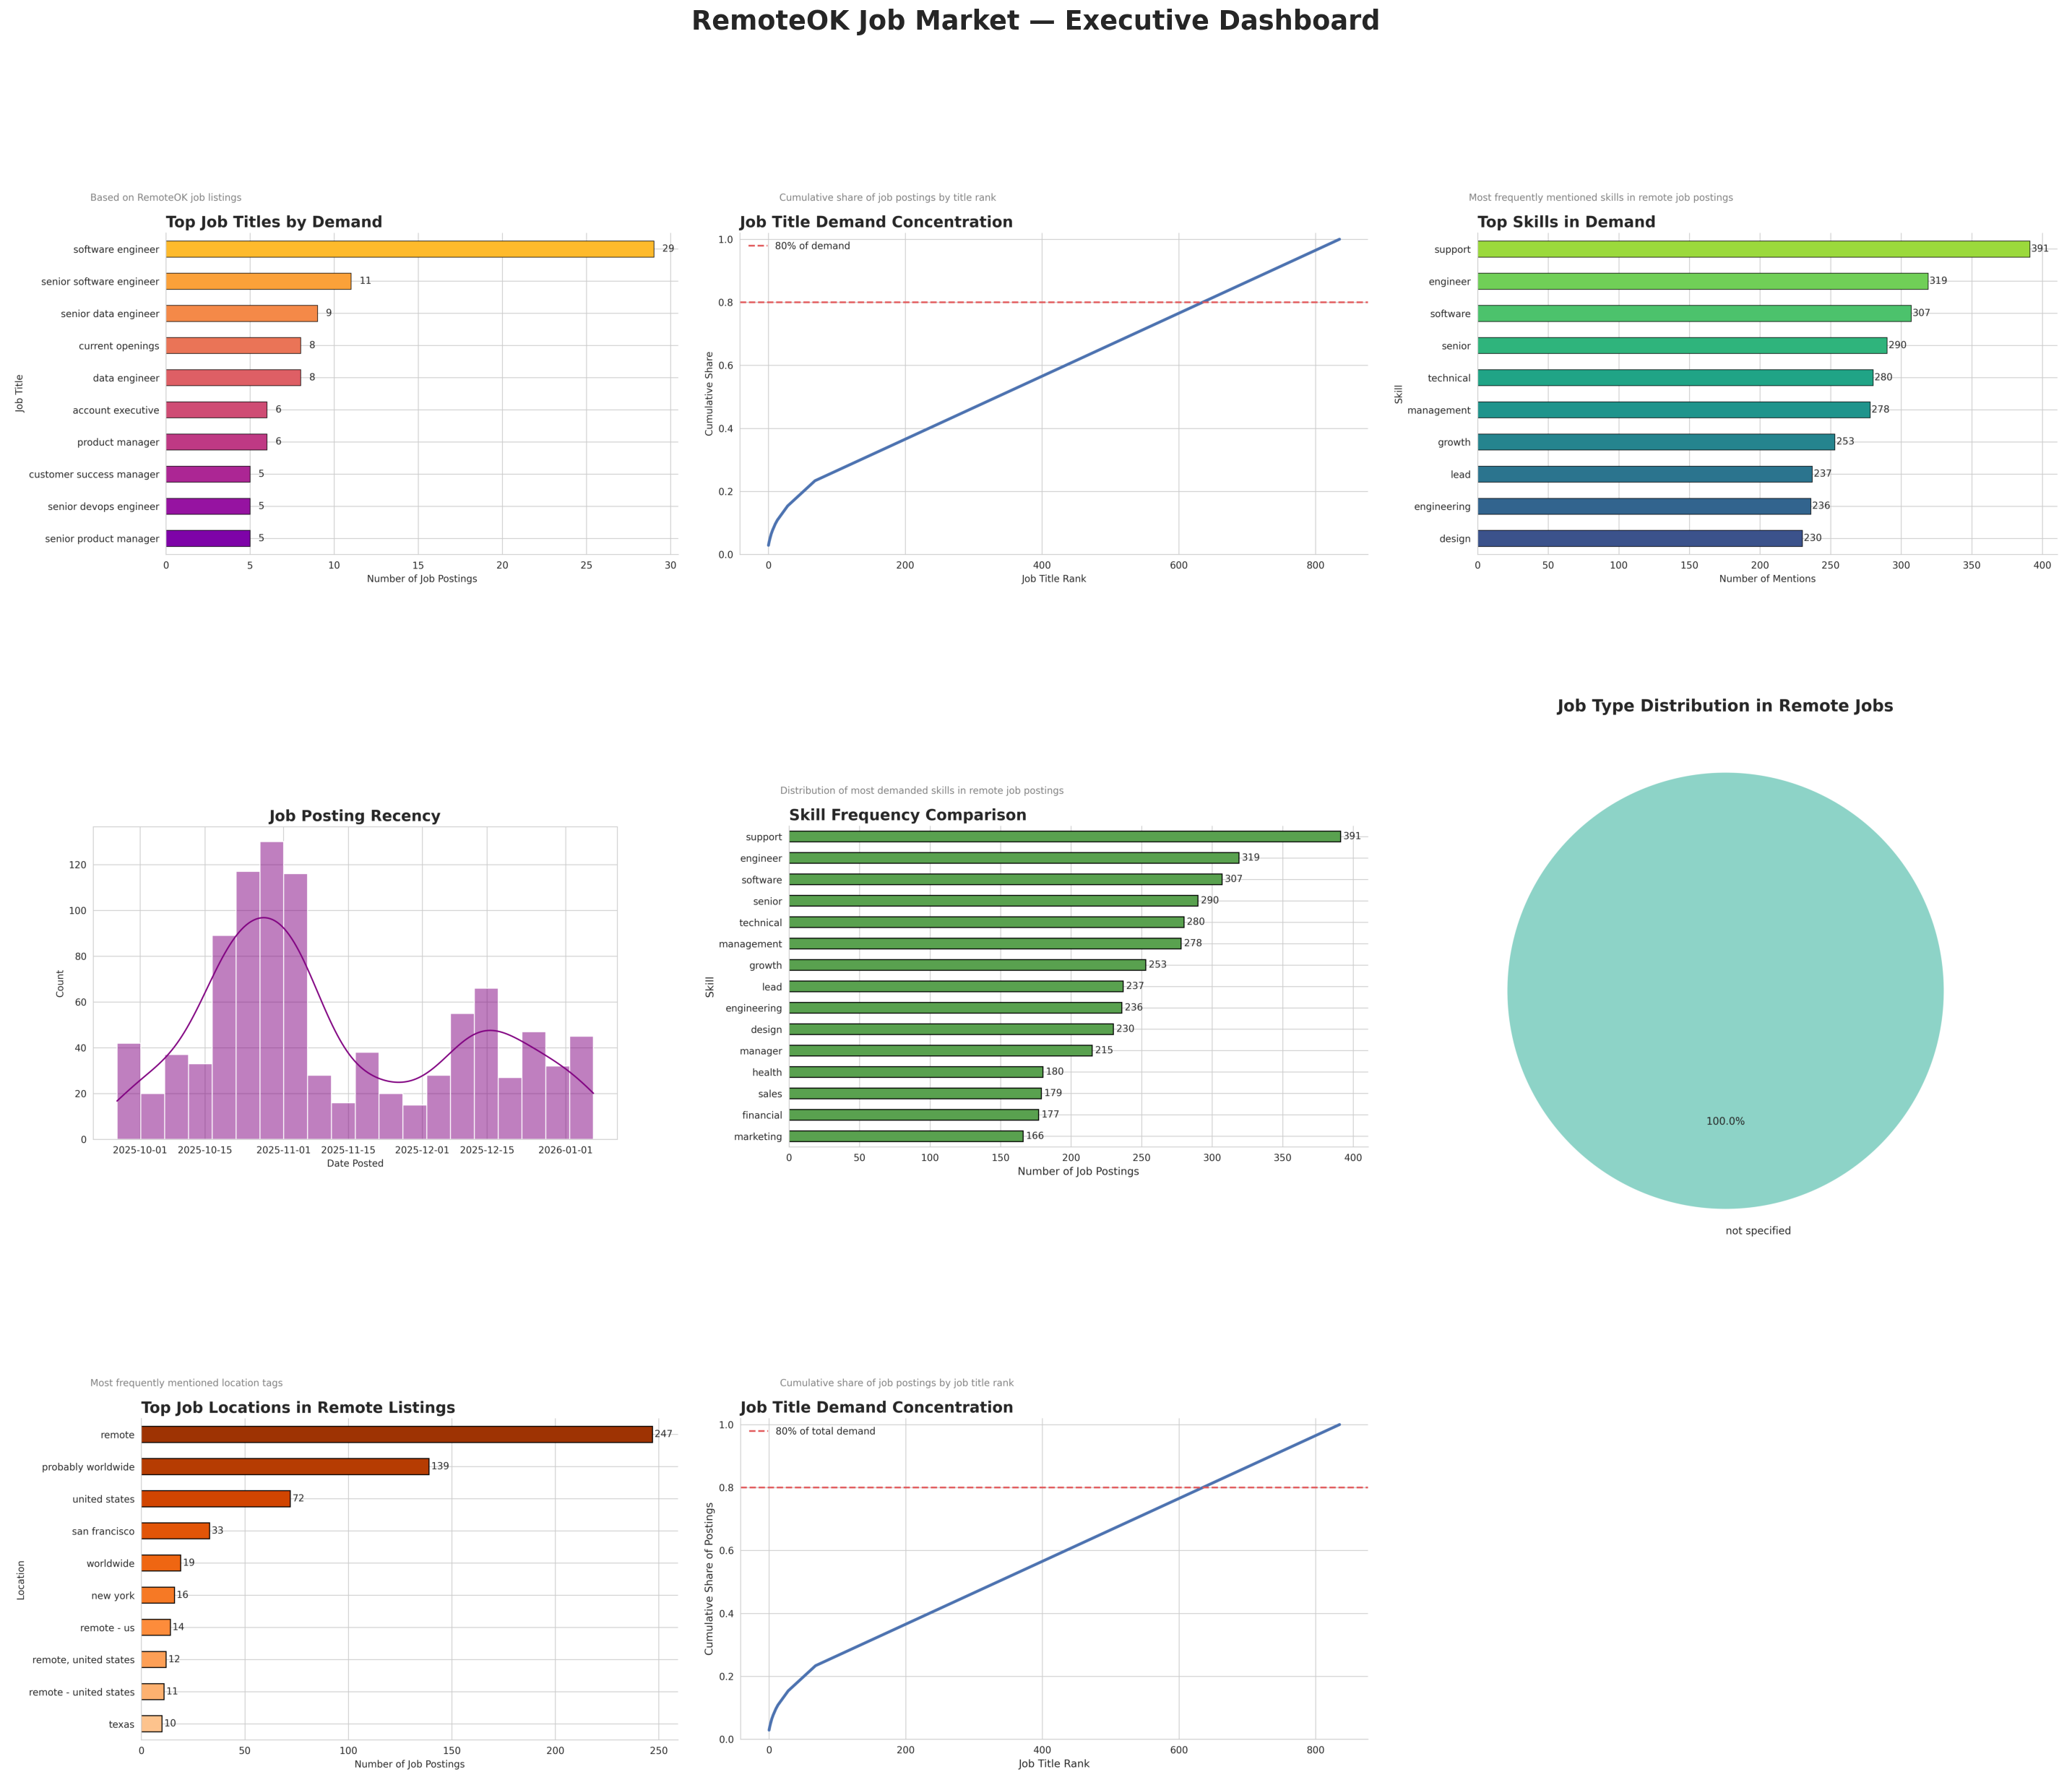

In [ ]:
fig = plt.figure(figsize=(24,22))
gs = GridSpec(3,3)

images = sorted(PLOTS_DIR.glob("*.png"))

for i, img in enumerate(images):
    ax = fig.add_subplot(gs[i])
    ax.imshow(plt.imread(img))
    ax.axis("off")

plt.suptitle("RemoteOK Job Market — Executive Dashboard",
             fontsize=22, weight="bold")
plt.tight_layout(rect=[0,0,1,0.96])
plt.savefig(DASHBOARD_DIR / "remoteok_executive_dashboard.png", dpi=300)
plt.show()